In [1]:
#figures 1i and 1j. multimodal macroscale validations of expression maps

In [ ]:
import scripts.neurosynth_tools as nt
from scripts.mapping_helpers import get_indices
import pandas as pd
import numpy as np
import os
import nibabel as nb
import matplotlib.pyplot as plt
import matplotlib_surface_plotting as msp
import seaborn as sns
import scripts.per_vertex_bb as pvb

In [2]:
#load in gene data
base_dir = '/data1/allen_surfaces/'
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0
concat=np.load(os.path.join(base_dir,'all_subs_smoothed_z.npy'))
surf=nb.load(os.path.join(base_dir,'hcp_surfs', 'fs_LR32k',
                                'fs_LR.32k.L.inflated.surf.gii'))
concat_cortex = concat[:,cortex]

In [3]:
#Betz cell validation. von economo neurons showed correct distribution but no independent atlas.
maps=np.zeros((2,len(cortex)))
cells = ['Betz','VENs']
for k,cell in enumerate(cells):
    marker_lists = pd.read_excel('von_economo_neurons/cell_lists.xlsx',sheet_name=cell)
    indices=get_indices(marker_lists['Genes'])[0]
    maps[k] = np.mean(concat[indices],axis=0)
    break

In [3]:
glasser=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
invert_dict=glasser.labeltable.get_labels_as_dict()
dictionary={}
for k in invert_dict.keys():
    dictionary[invert_dict[k]]=k
glasser_parcellation=glasser.darrays[0].data
areas=['L_4_ROI','L_6ma_ROI','L_6d_ROI',
       'L_6mp_ROI','L_6v_ROI','L_6r_ROI',
       'L_6a_ROI','L_FEF_ROI']
motor_mask = np.zeros(len(cortex))
for area in areas:
    location=dictionary[area]
    motor_mask[glasser_parcellation==location]+=1

In [4]:
from matplotlib.colors import  LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('binary', [np.array([0.86,0.86,0.86,1]), 'red'])


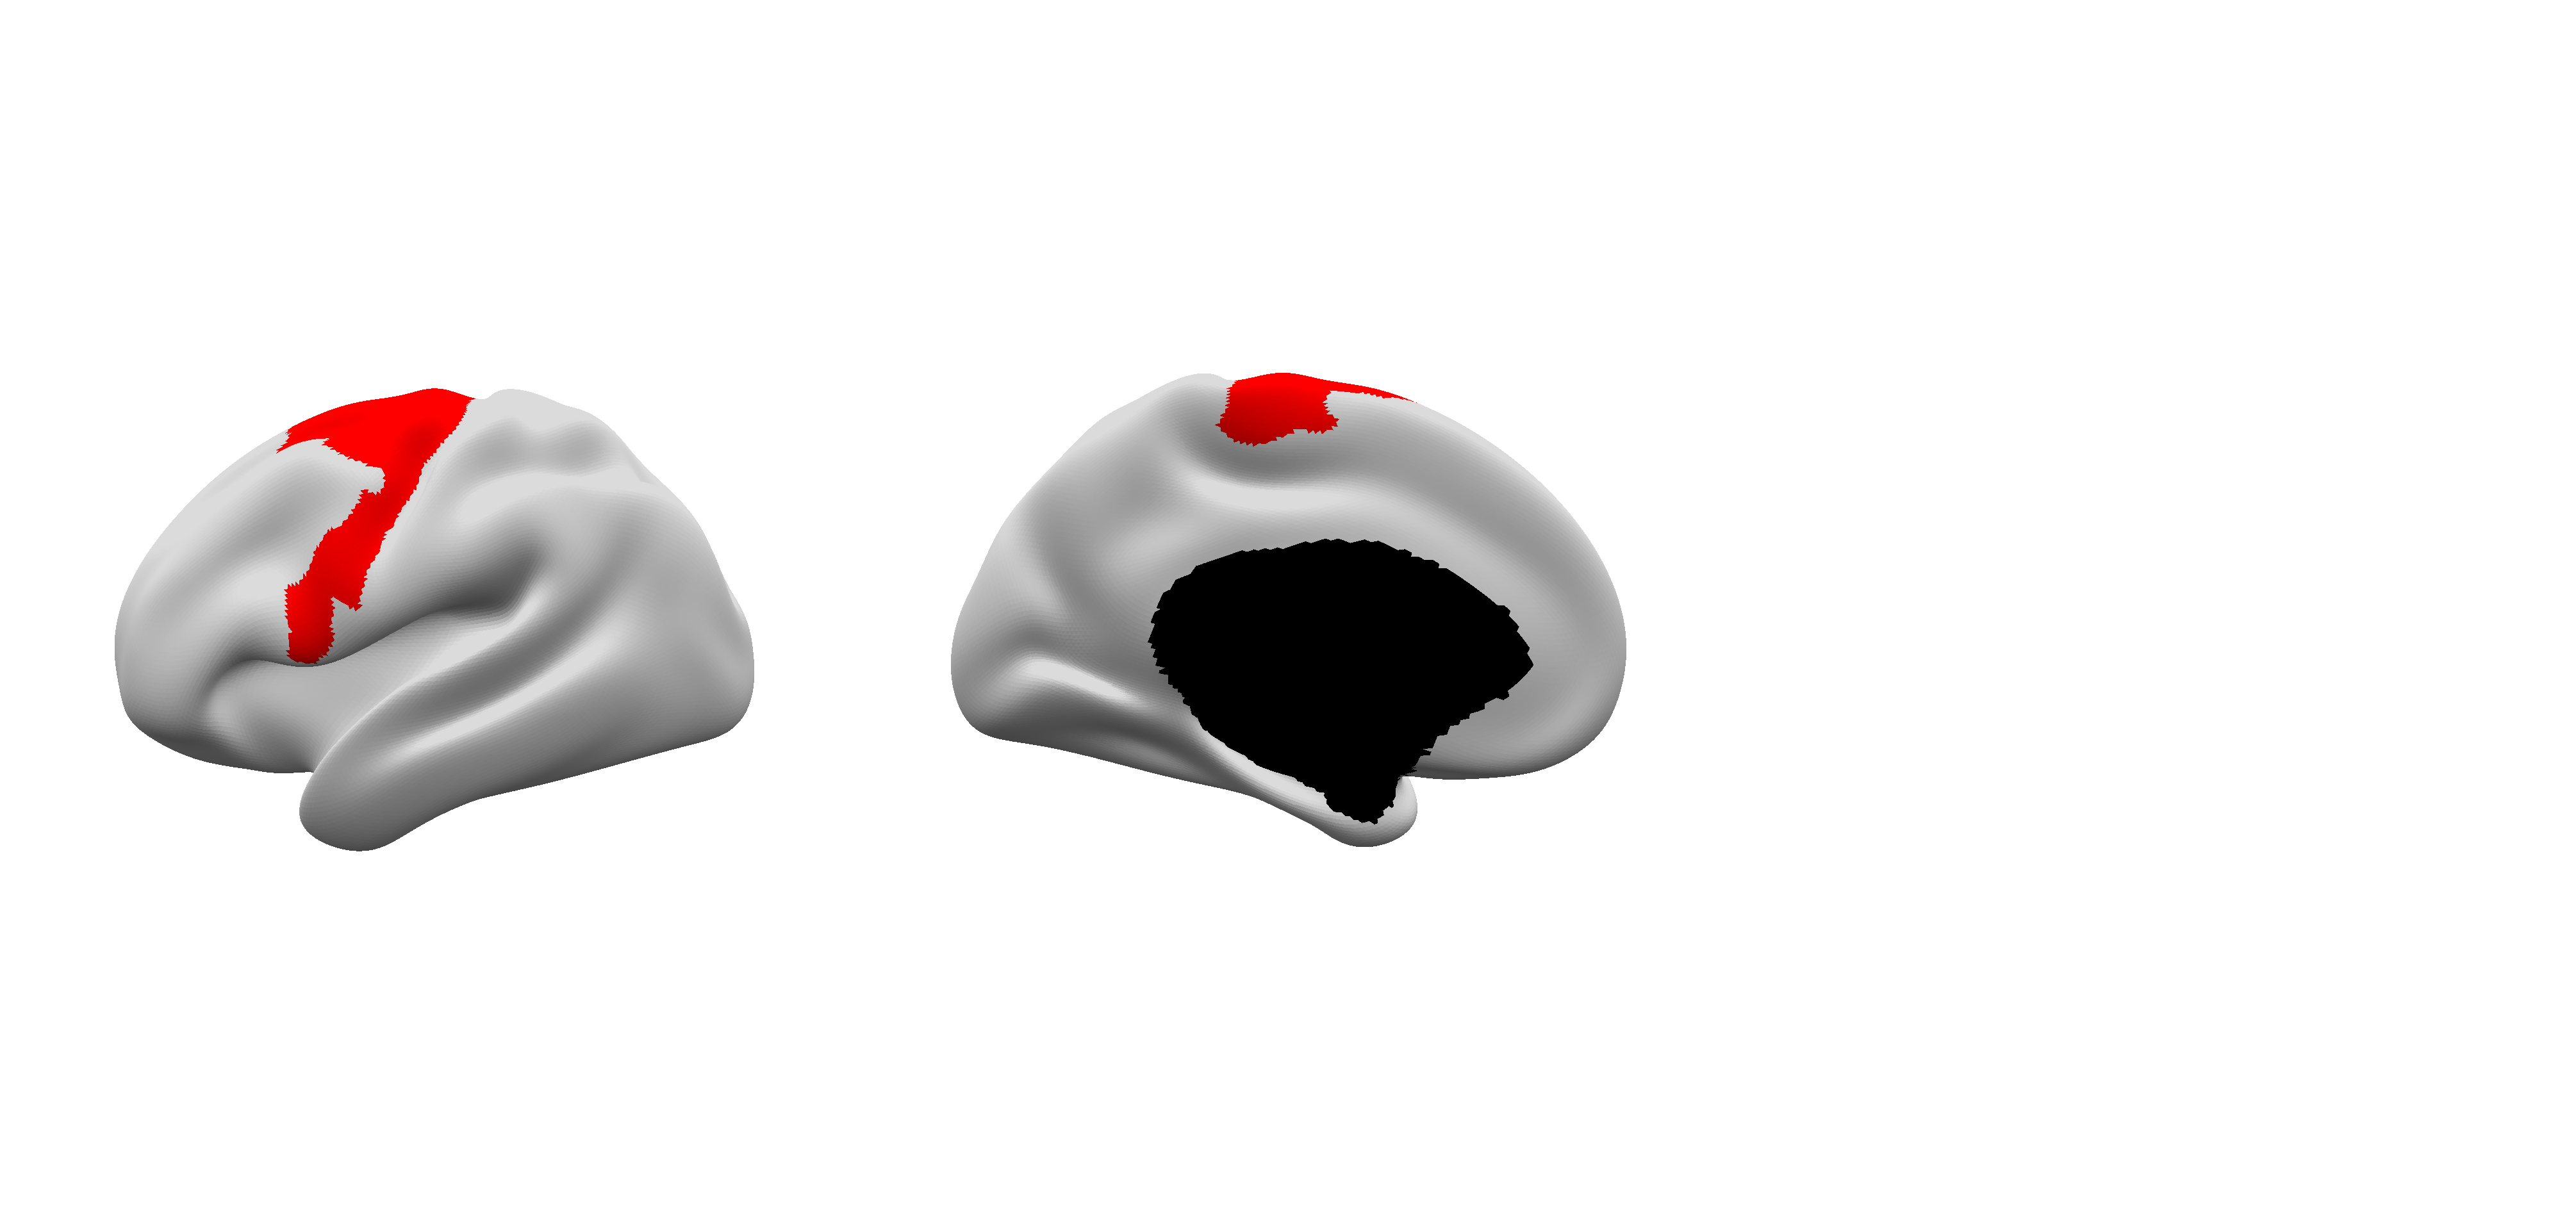

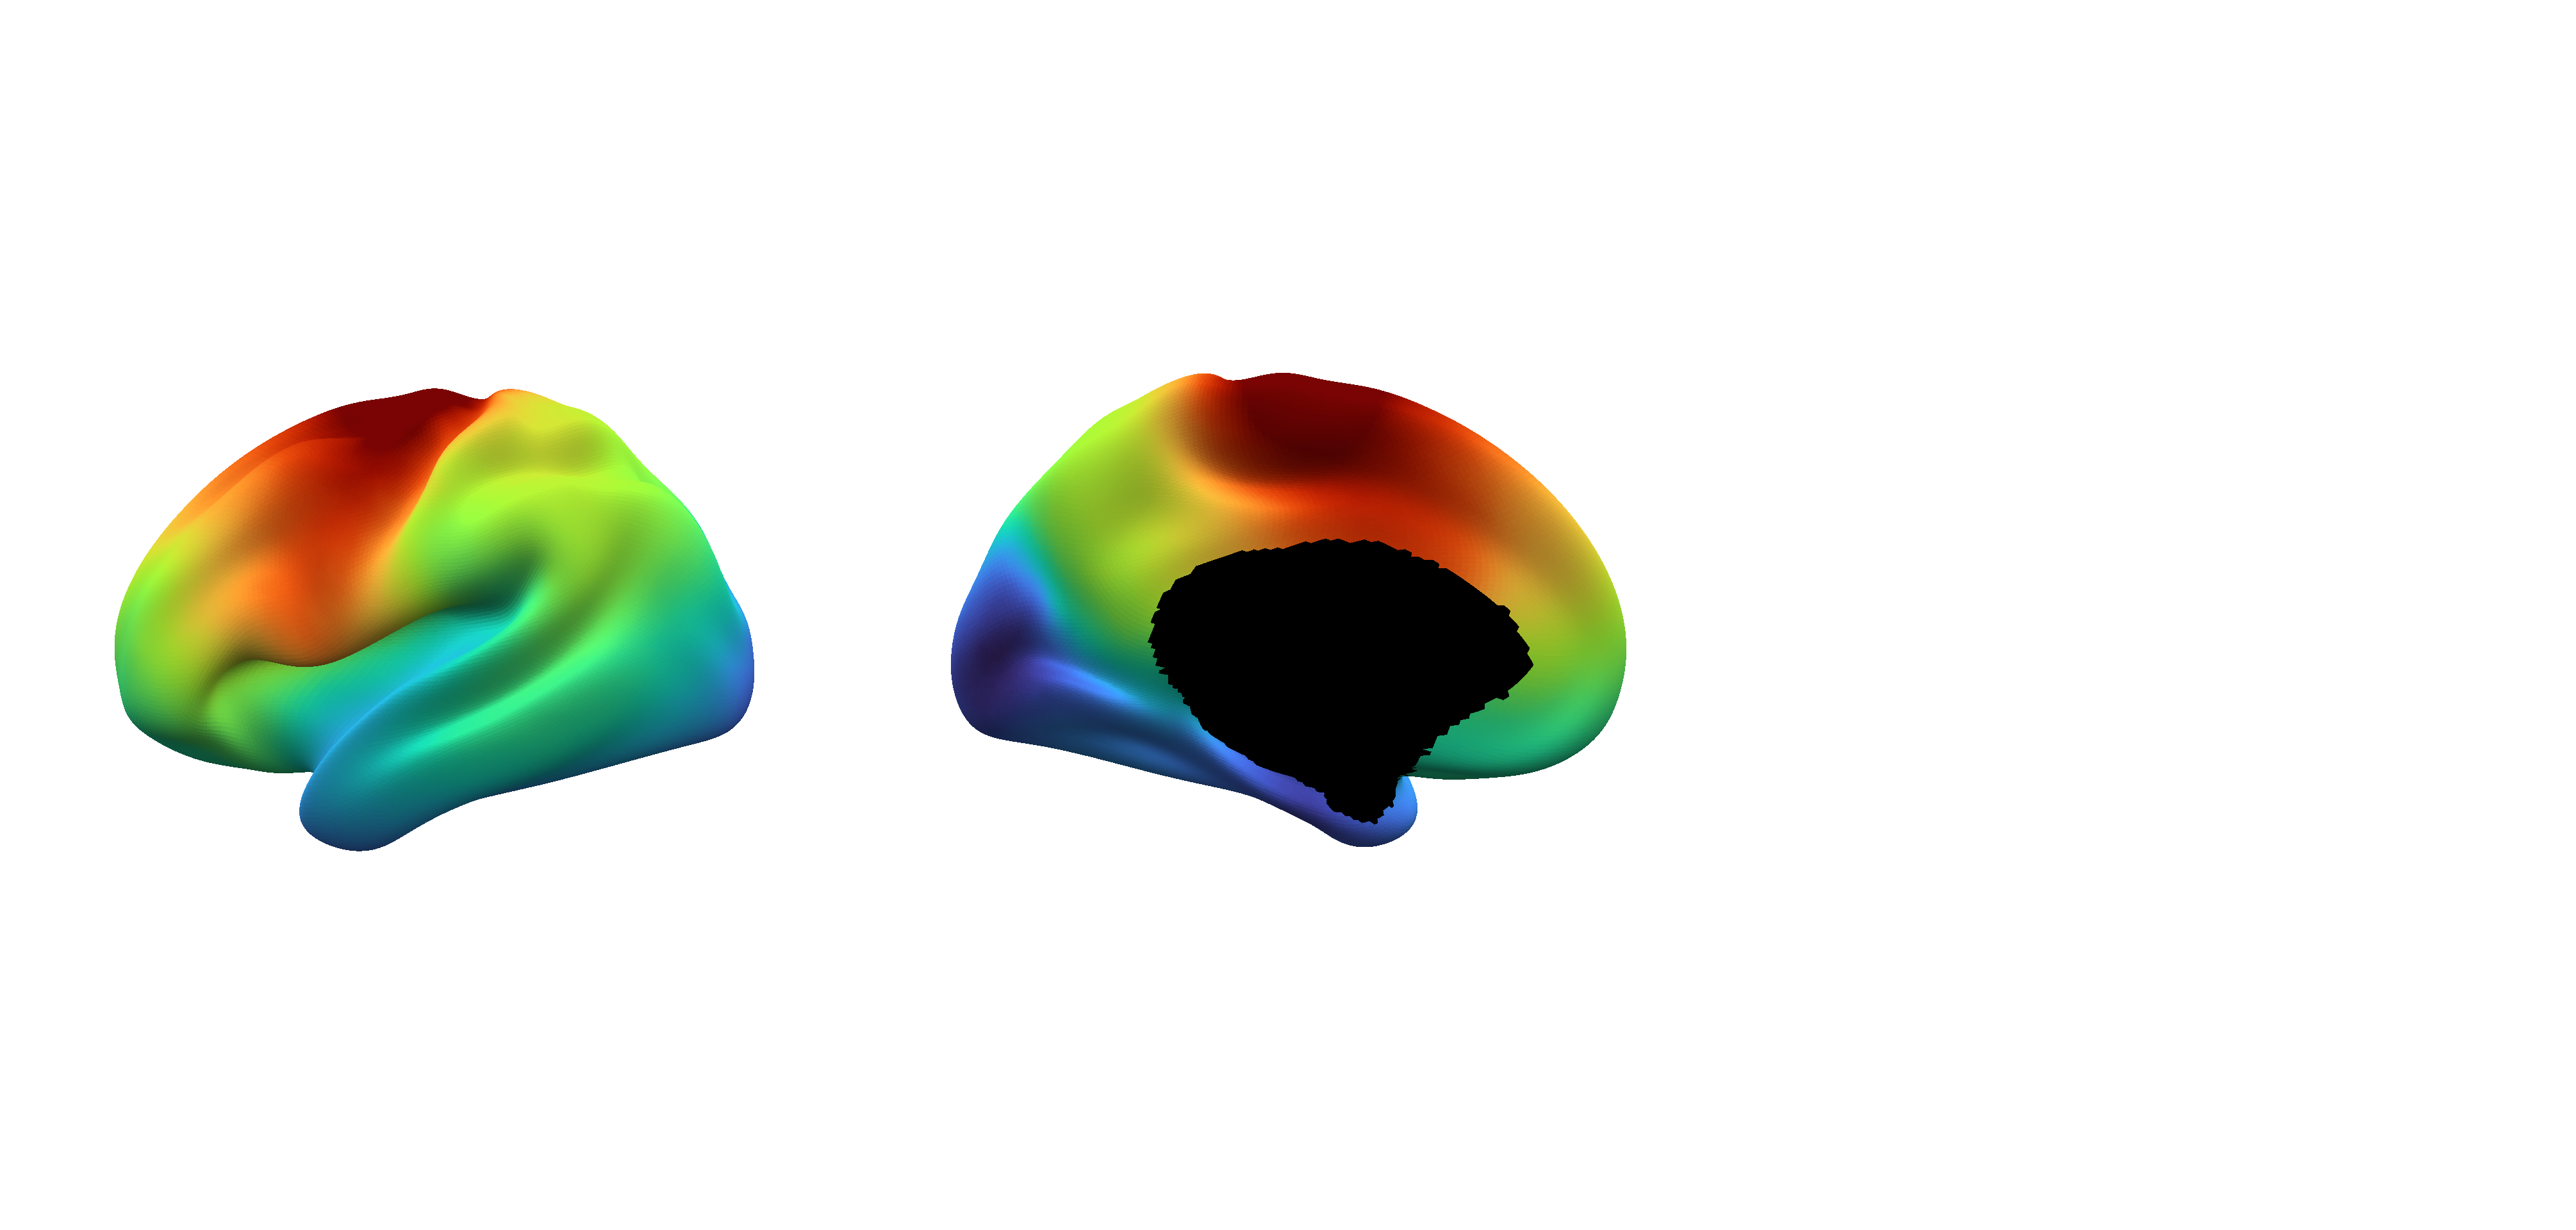

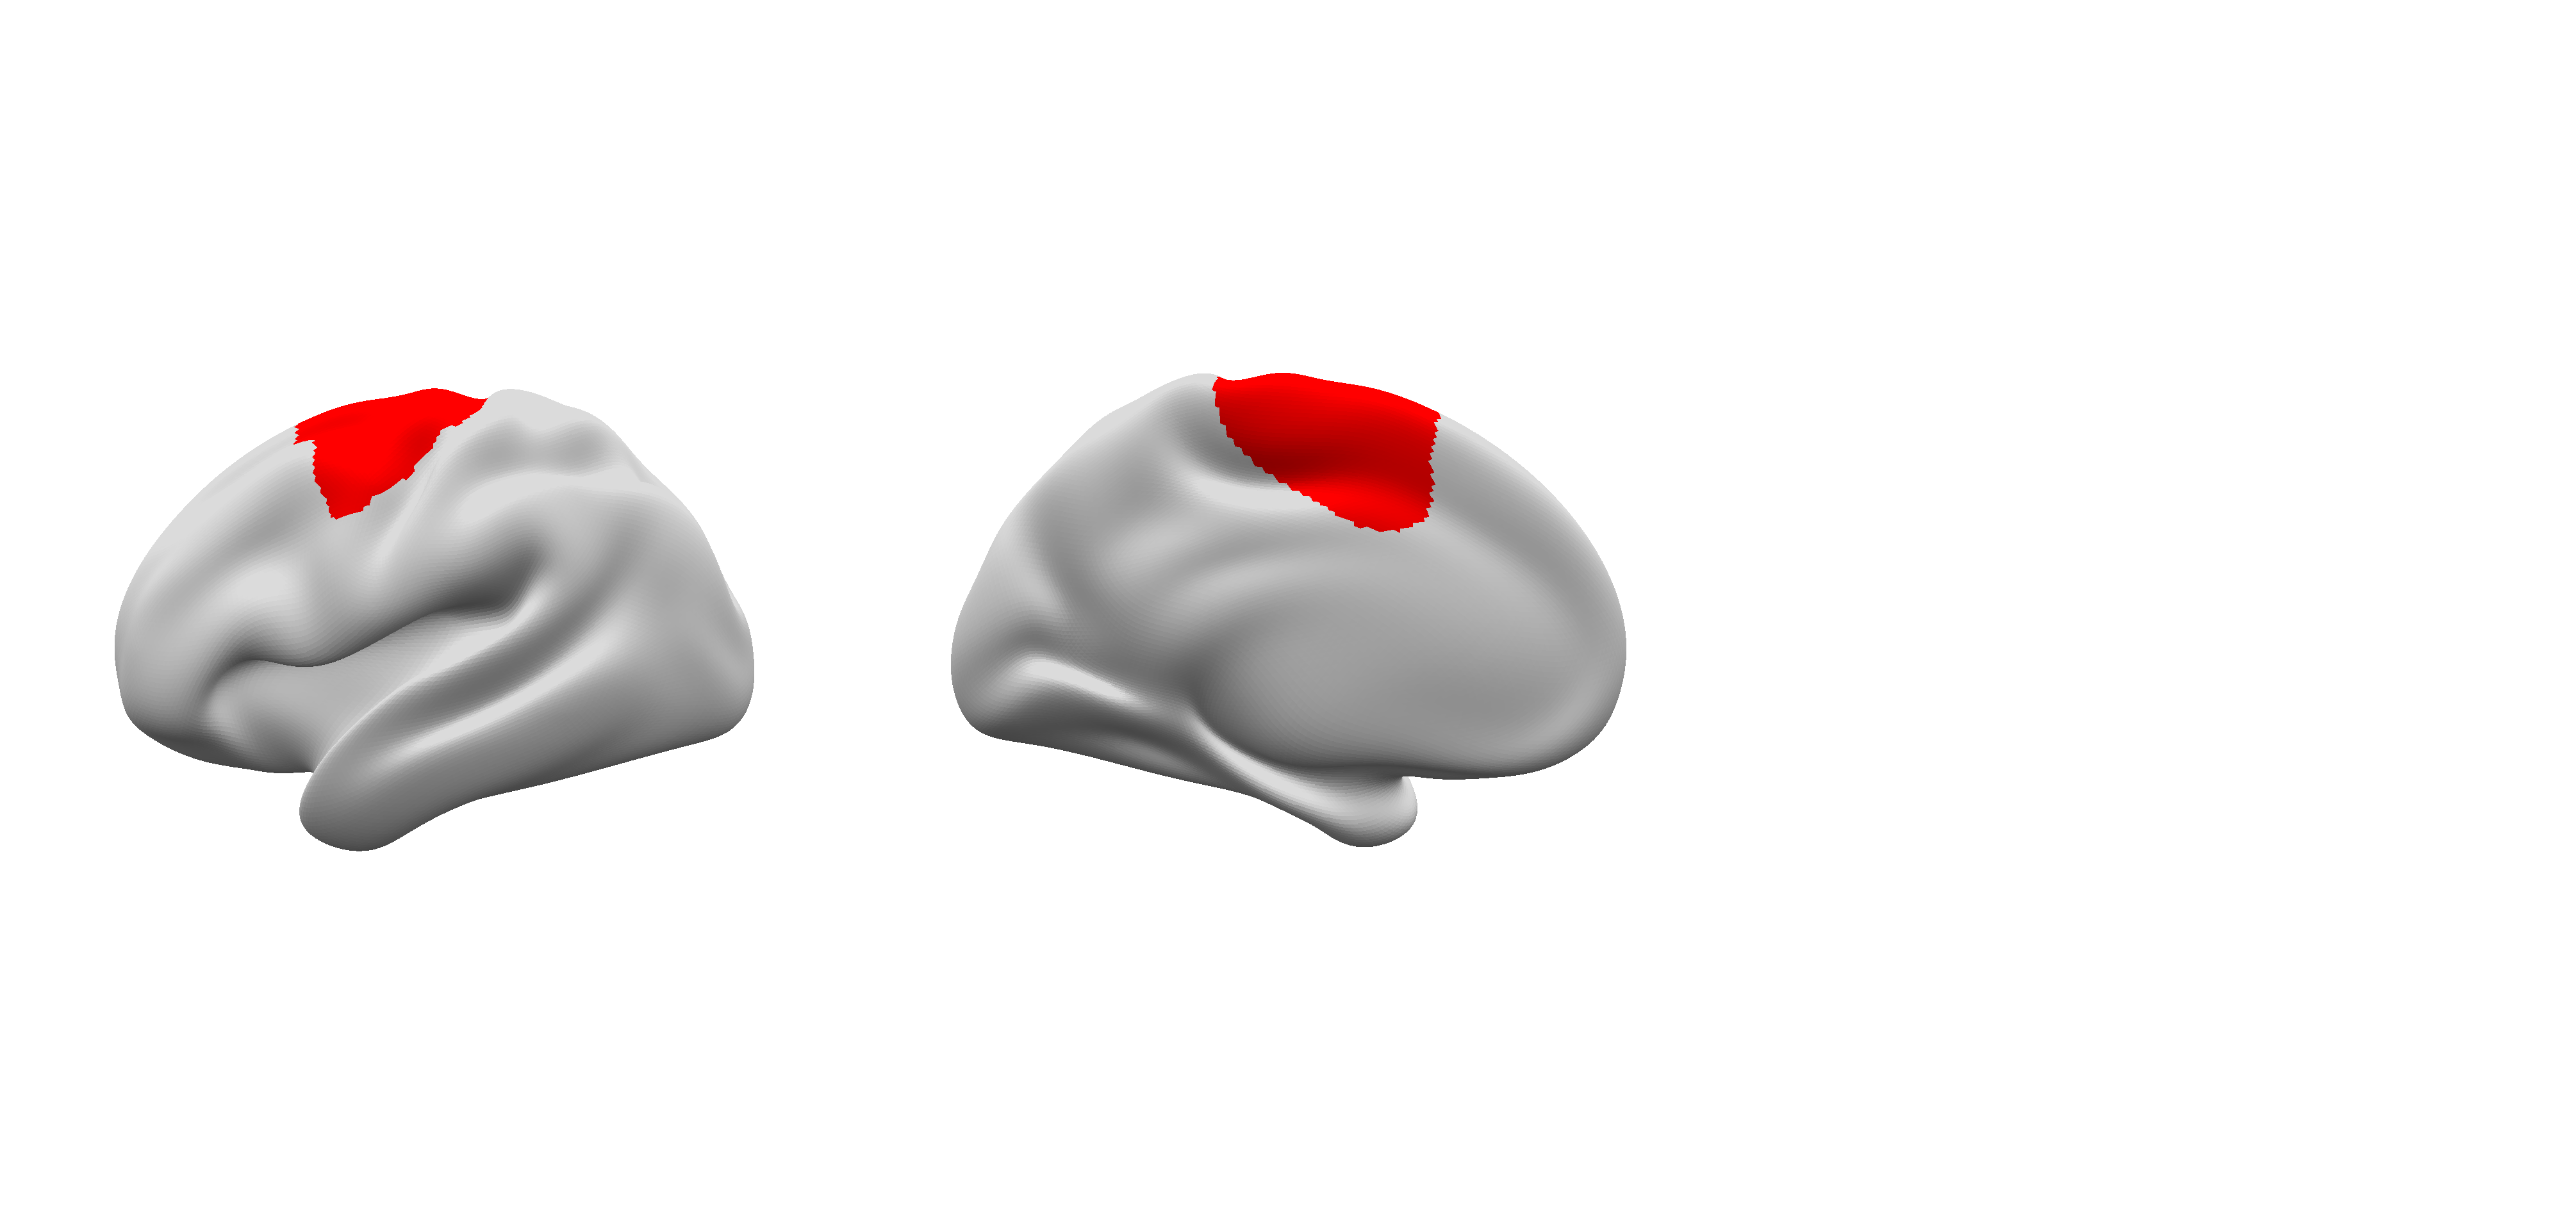

In [8]:
surf=nb.load(os.path.join(base_dir,'hcp_surfs', 'fs_LR32k',
                                'fs_LR.32k.L.inflated.surf.gii'))
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,motor_mask,
                  rotate=[90,270],label=True,
                 cmap=cmap,vmin=0,base_size=20,
                  vmax=1,mask=~cortex,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
                  colorbar=False,
                  filename='figures/motor_mask_glasser.png'
                 )

m=maps[0]
m=(m-np.mean(m[cortex]))/np.std(m[cortex])
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,m,
              rotate=[90,270],base_size=20,
             cmap='turbo',vmin=-2,
              vmax=2,mask=~cortex,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
              colorbar=False,
              filename='figures/bakken_betz_neurons.png'
             )

m=(m>np.percentile(m[cortex],90)).astype(int)
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,m,
              rotate=[90,270],base_size=20,label=True,
             cmap='bwr',vmin=np.percentile(m[cortex],5),
              vmax=1,mask=m==0,pvals=np.ones_like(cortex),
              colorbar=False,
              filename='figures/bakken_betz_neurons_masked.png'
             )

In [9]:
map_c = maps[0,cortex]
motor_c = motor_mask[cortex]==1

In [ ]:
deltas_all_g = np.median(concat_cortex[:,motor_c],axis=1) - np.median(concat_cortex[:,~motor_c],axis=1)
n_perm=1000
ranked_deltas = deltas_all_g.argsort().argsort()
median_rank = np.median(ranked_deltas[indices])
perm_ranks = np.zeros(n_perm)
for perm in np.arange(n_perm):
    perm_ranks[perm] = np.median(np.random.choice(ranked_deltas,2))

0.001

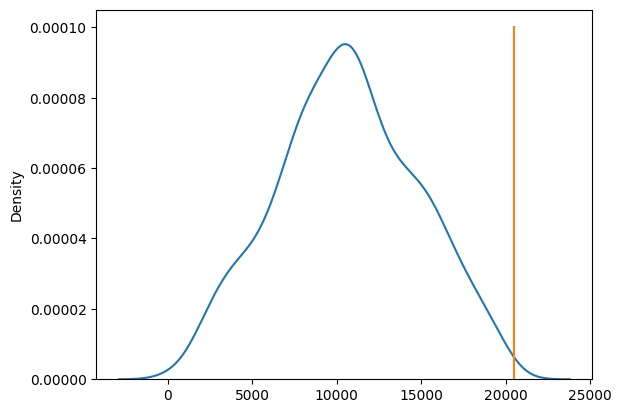

In [ ]:
sns.kdeplot(perm_ranks) 
plt.plot([median_rank,median_rank],[0,.0001],)
np.mean(perm_ranks>median_rank)

In [5]:
n_perm=10000
spins= np.load(f'spin_dir/spins_{n_perm}.npy')

In [ ]:

deltas=np.median(map_c[motor_c])-np.median(map_c[~motor_c])
perm_deltas = np.zeros((n_perm))
stored=[]
for p in np.arange(n_perm):
    p1=np.random.randint(10000)
    p2=np.random.randint(10000)
    spin =spins[p1]
    spun_maps=map_c[spin]
    spin =spins[p2]
    spun_binary_maps=motor_c[spin]
    perm_deltas[p]=np.median(spun_maps[spun_binary_maps])-np.median(spun_maps[~spun_binary_maps])
    if perm_deltas[p]> deltas:
        stored.append(spun_binary_maps)
nt_scores = (deltas-np.mean(perm_deltas,axis=0))/np.std(perm_deltas,axis=0)
p_val = np.abs(0.5-np.abs(0.5-np.mean(deltas<perm_deltas,axis=0)))


In [ ]:
sns.kdeplot(perm_deltas)
plt.plot([deltas,deltas],[0,0.6])
deltas,p_val

In [ ]:
map_c = maps[0,cortex]
map_c = map_c>np.percentile(map_c,95)
motor_c = motor_mask[cortex]==1

deltas=np.mean(map_c[motor_c])-np.mean(map_c[~motor_c])
perm_deltas = np.zeros((n_perm))
stored=[]
for p in np.arange(n_perm):
    p1=np.random.randint(10000)
    p2=np.random.randint(10000)
    if p2==p1:
        p2=np.random.randint(10000)
    spin =spins[p1]
    spun_maps=map_c[spin]
    spin =spins[p2]
    
    spun_binary_maps=motor_c[spin]
    perm_deltas[p]=np.mean(spun_maps[spun_binary_maps])-np.mean(spun_maps[~spun_binary_maps])
    if perm_deltas[p]> deltas:
        stored.append(spun_binary_maps)
nt_scores = (deltas-np.mean(perm_deltas,axis=0))/np.std(perm_deltas,axis=0)
p_val = np.abs(0.5-np.abs(0.5-np.mean(deltas<perm_deltas,axis=0)))
sns.kdeplot(perm_deltas)
plt.plot([deltas,deltas],[0,0.6])
deltas,p_val

In [6]:
from goatools.base import get_godag
#godag = get_godag('go-basic.obo', optional_attrs='relationship')
#['GO:0097447'].

In [12]:
taxid=9606
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

# download associations
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()

# load ontology
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

# load human gene ontology
from goatools.anno.genetogo_reader import Gene2GoReader
objanno = Gene2GoReader(fin_gene2go, taxids=[taxid]) #9606 is taxonomy ID for homo sapiens
ns2assoc = objanno.get_ns2assc()

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-10-09) 47,313 Terms
HMS:0:00:03.020182 336,356 annotations, 20,586 genes, 18,410 GOs, 1 taxids READ: gene2go 


In [13]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
#df_genehumans = pd.read_csv('data/df_human_geneinfo.csv',index_col=0)
df = pd.read_csv('armin_data/donor10021_preprocessed/donor10021_genes.ra.csv')
# if no reference list is given, default to all genes in ABHA

    #ref_list = np.union1d(df['gene.entrez_id'],df_genehumans['GeneID']).tolist()
ref_list = df['gene.entrez_id'].tolist()
    #ref_list = df_genehumans['GeneID'].to_list()

#logging can be turned off here somehow
goeaobj = GOEnrichmentStudyNS(ref_list, ns2assoc, obodag, 
                              propagate_counts=True, alpha=0.05, methods=['fdr_bh'])
symbol2id_dict = dict(zip(df['gene.symbol'].str.upper(), df['gene.entrez_id']))
id2symbol = dict(zip( df['gene.entrez_id'],df['gene.symbol'].str.upper()))


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a


17 GO IDs NOT FOUND IN ASSOCIATION: GO:0032800 GO:0010871 GO:0045714 GO:0051088 GO:0009108 GO:0051181 GO:0045713 GO:0045212 GO:0045716 GO:1900062 GO:0010870 GO:1903759 GO:0001302 GO:0051186 GO:0010869 GO:0045715 GO:0045189


 80% 16,621 of 20,781 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 84% 17,496 of 20,781 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a


2 GO IDs NOT FOUND IN ASSOCIATION: GO:0005623 GO:0042643
3 GO IDs NOT FOUND IN ASSOCIATION: GO:0048037 GO:0051184 GO:0050662


 80% 16,538 of 20,781 population items found in association


In [15]:
myelin_term ='GO:0043209'
genes_in_term=[]
bool_myelin= np.zeros(len(df),dtype=bool)
for gene in ns2assoc['CC']:
    if myelin_term in ns2assoc['CC'][gene]:
        try:
            genes_in_term.append(id2symbol[gene])
            bool_myelin[df['gene.symbol']==id2symbol[gene]]=1
        except KeyError:
            pass

In [16]:
#get myelin basic protein
genes_oi=['MBP']
bool_myelin= np.zeros(len(df),dtype=bool)
indices,m=get_indices(genes_oi)
bool_myelin[indices]=1


In [19]:
myelin_map= np.mean(concat[bool_myelin], axis=0)

myelin_map = np.load('surface_mapping/mbp.npy')

In [21]:
myelin_mri = nb.load("/data1/S-A_ArchetypalAxis/FSLRVertex/T1T2ratio.L.func.gii").darrays[0].data



In [22]:
#spin
map_c=myelin_map[cortex]
mri_c=myelin_mri[cortex]
corr=np.corrcoef(map_c,mri_c)[0,1]

perm_corrs = np.zeros((n_perm))
for p in np.arange(n_perm):
    p1=np.random.randint(10000)
    p2=np.random.randint(10000)
    spin =spins[p1]
    spun_maps=map_c[spin]
    spin =spins[p2]
    spun_h_maps=mri_c[spin]
    perm_corrs[p]=np.corrcoef(spun_maps,spun_h_maps)[0,1]
    
# nt_scores = (deltas-np.mean(perm_deltas,axis=0))/np.std(perm_deltas,axis=0)
p_val = np.mean(corr<perm_corrs,axis=0)
corr,p_val

(0.5728777421384905, 0.0)

In [18]:
#gene_null
permed_ps = np.zeros(20781)
for i,g in enumerate(concat_cortex):
    permed_ps[i] = np.corrcoef(mri_c,g)[0,1]
np.mean(permed_ps > corr)

0.2968577065588759

In [ ]:
surf=nb.load(os.path.join(base_dir,'hcp_surfs', 'fs_LR32k',
                                'fs_LR.32k.L.inflated.surf.gii'))
myelin_mri = (myelin_mri-np.mean(myelin_mri[cortex]))/np.std(myelin_mri[cortex])
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,myelin_mri,
              rotate=[90,270],base_size=20,
             cmap='turbo',vmin=-2,
              vmax=2,mask=~cortex,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
              colorbar=False,
              filename='figures/t1t2_map.png'
             )

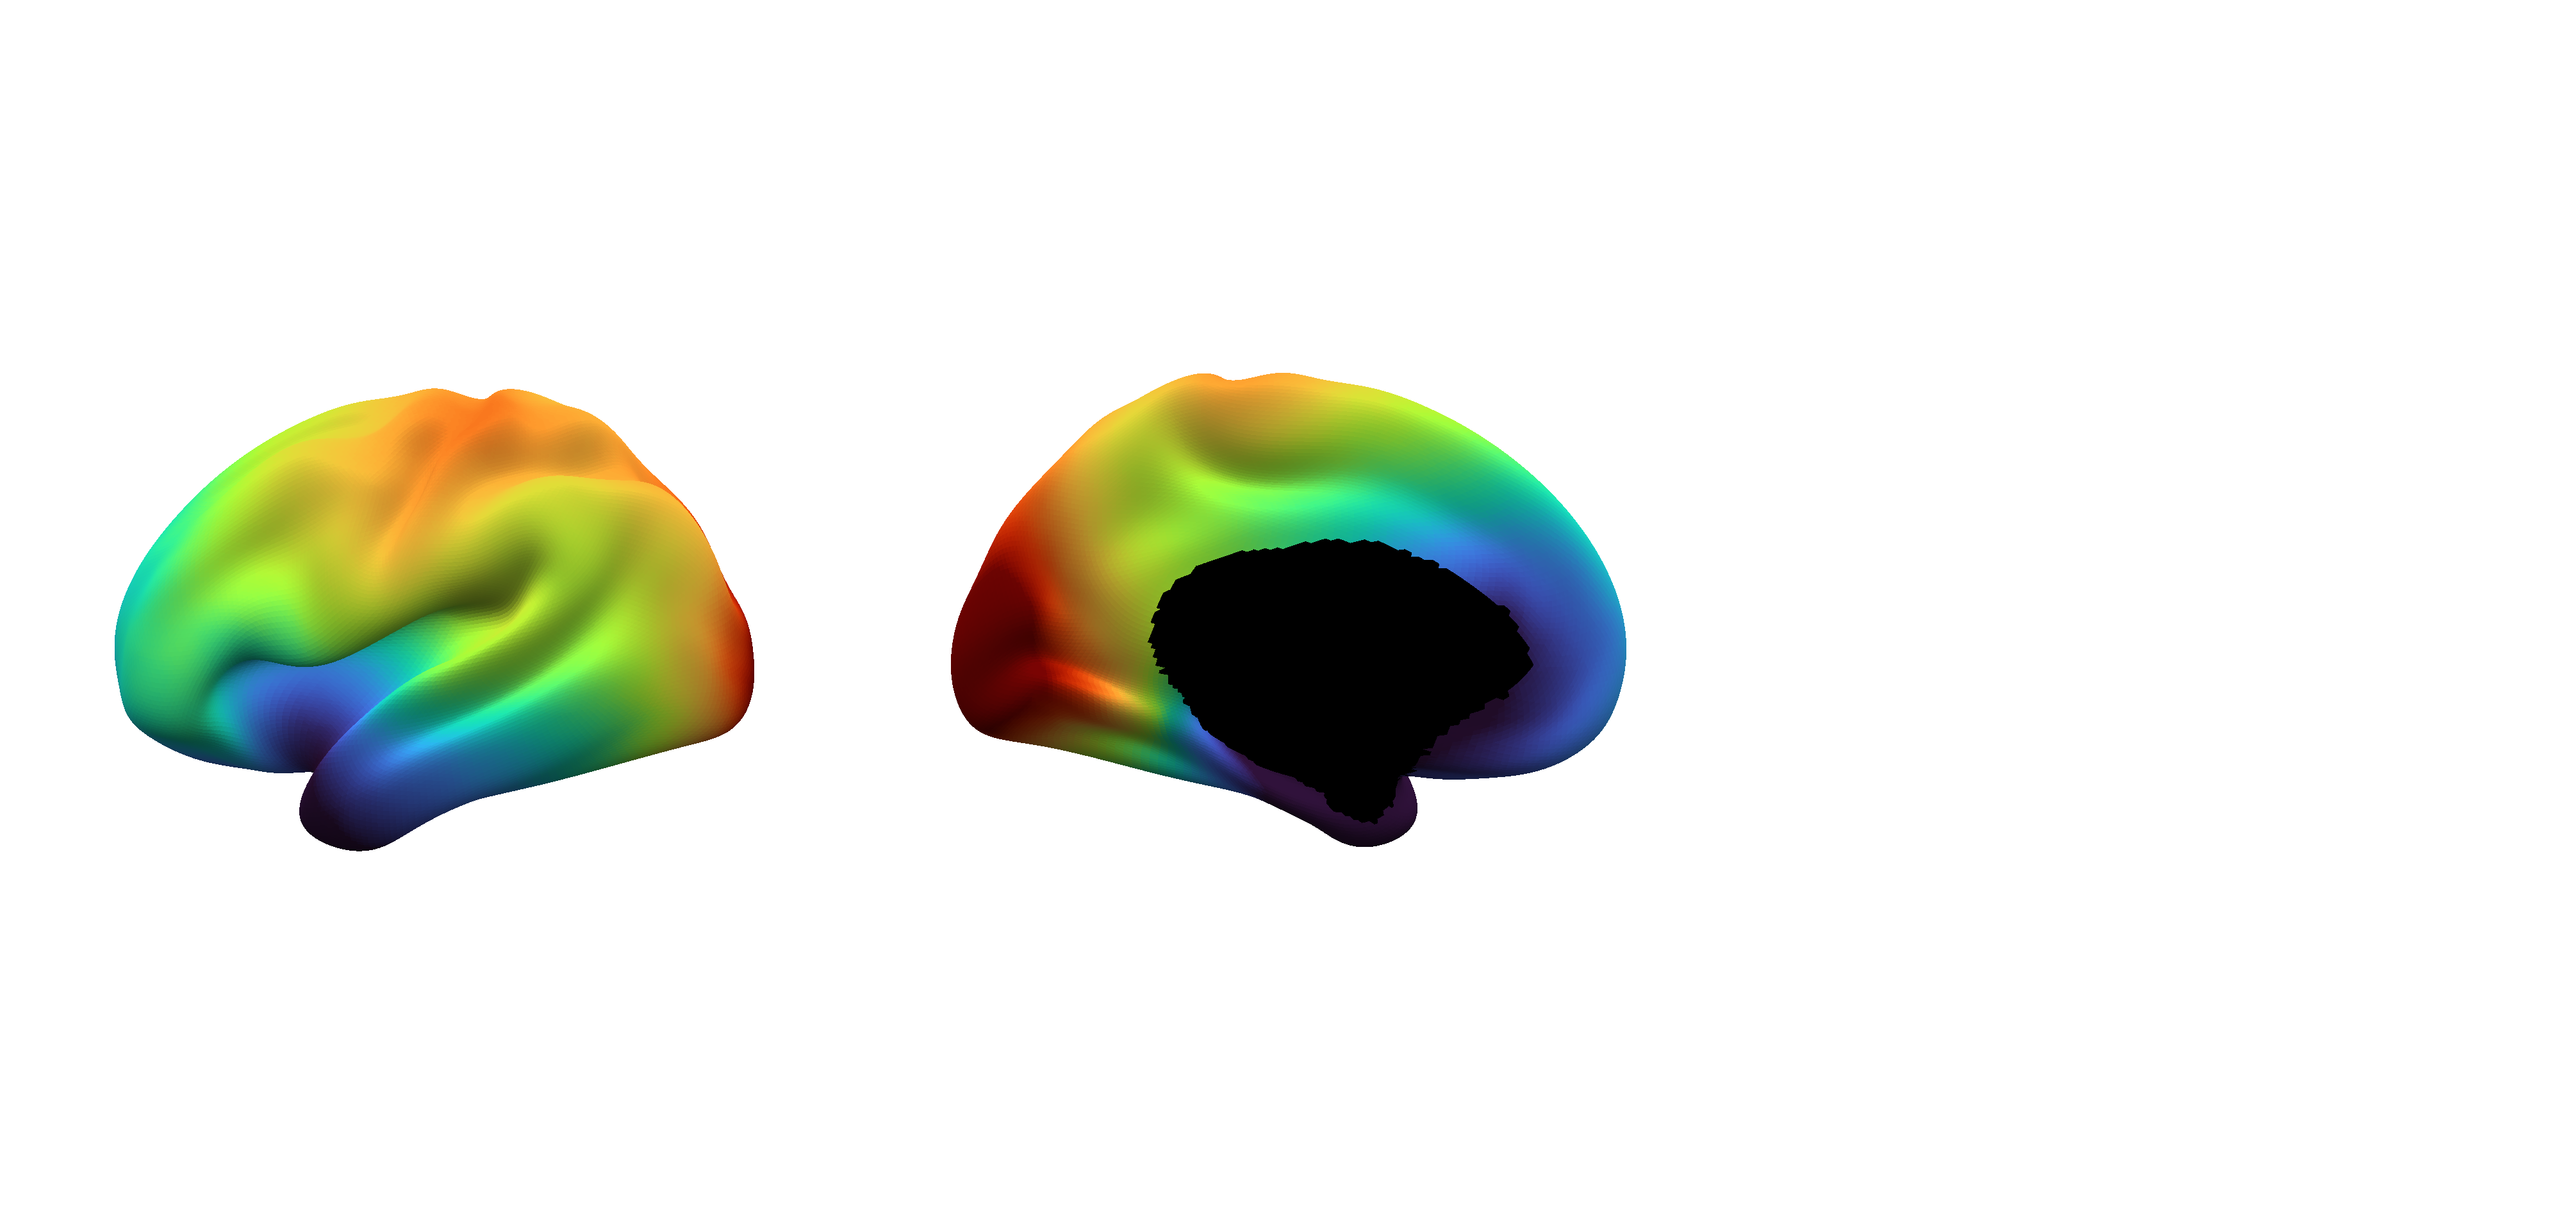

In [18]:
myelin_map = (myelin_map-np.mean(myelin_map[cortex]))/np.std(myelin_map[cortex])

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,myelin_map,
              rotate=[90,270],base_size=20,
             cmap='turbo',vmin=-2,
              vmax=2,mask=~cortex,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
              colorbar=False,              
                            filename='figures/mbp_map.png'

             )


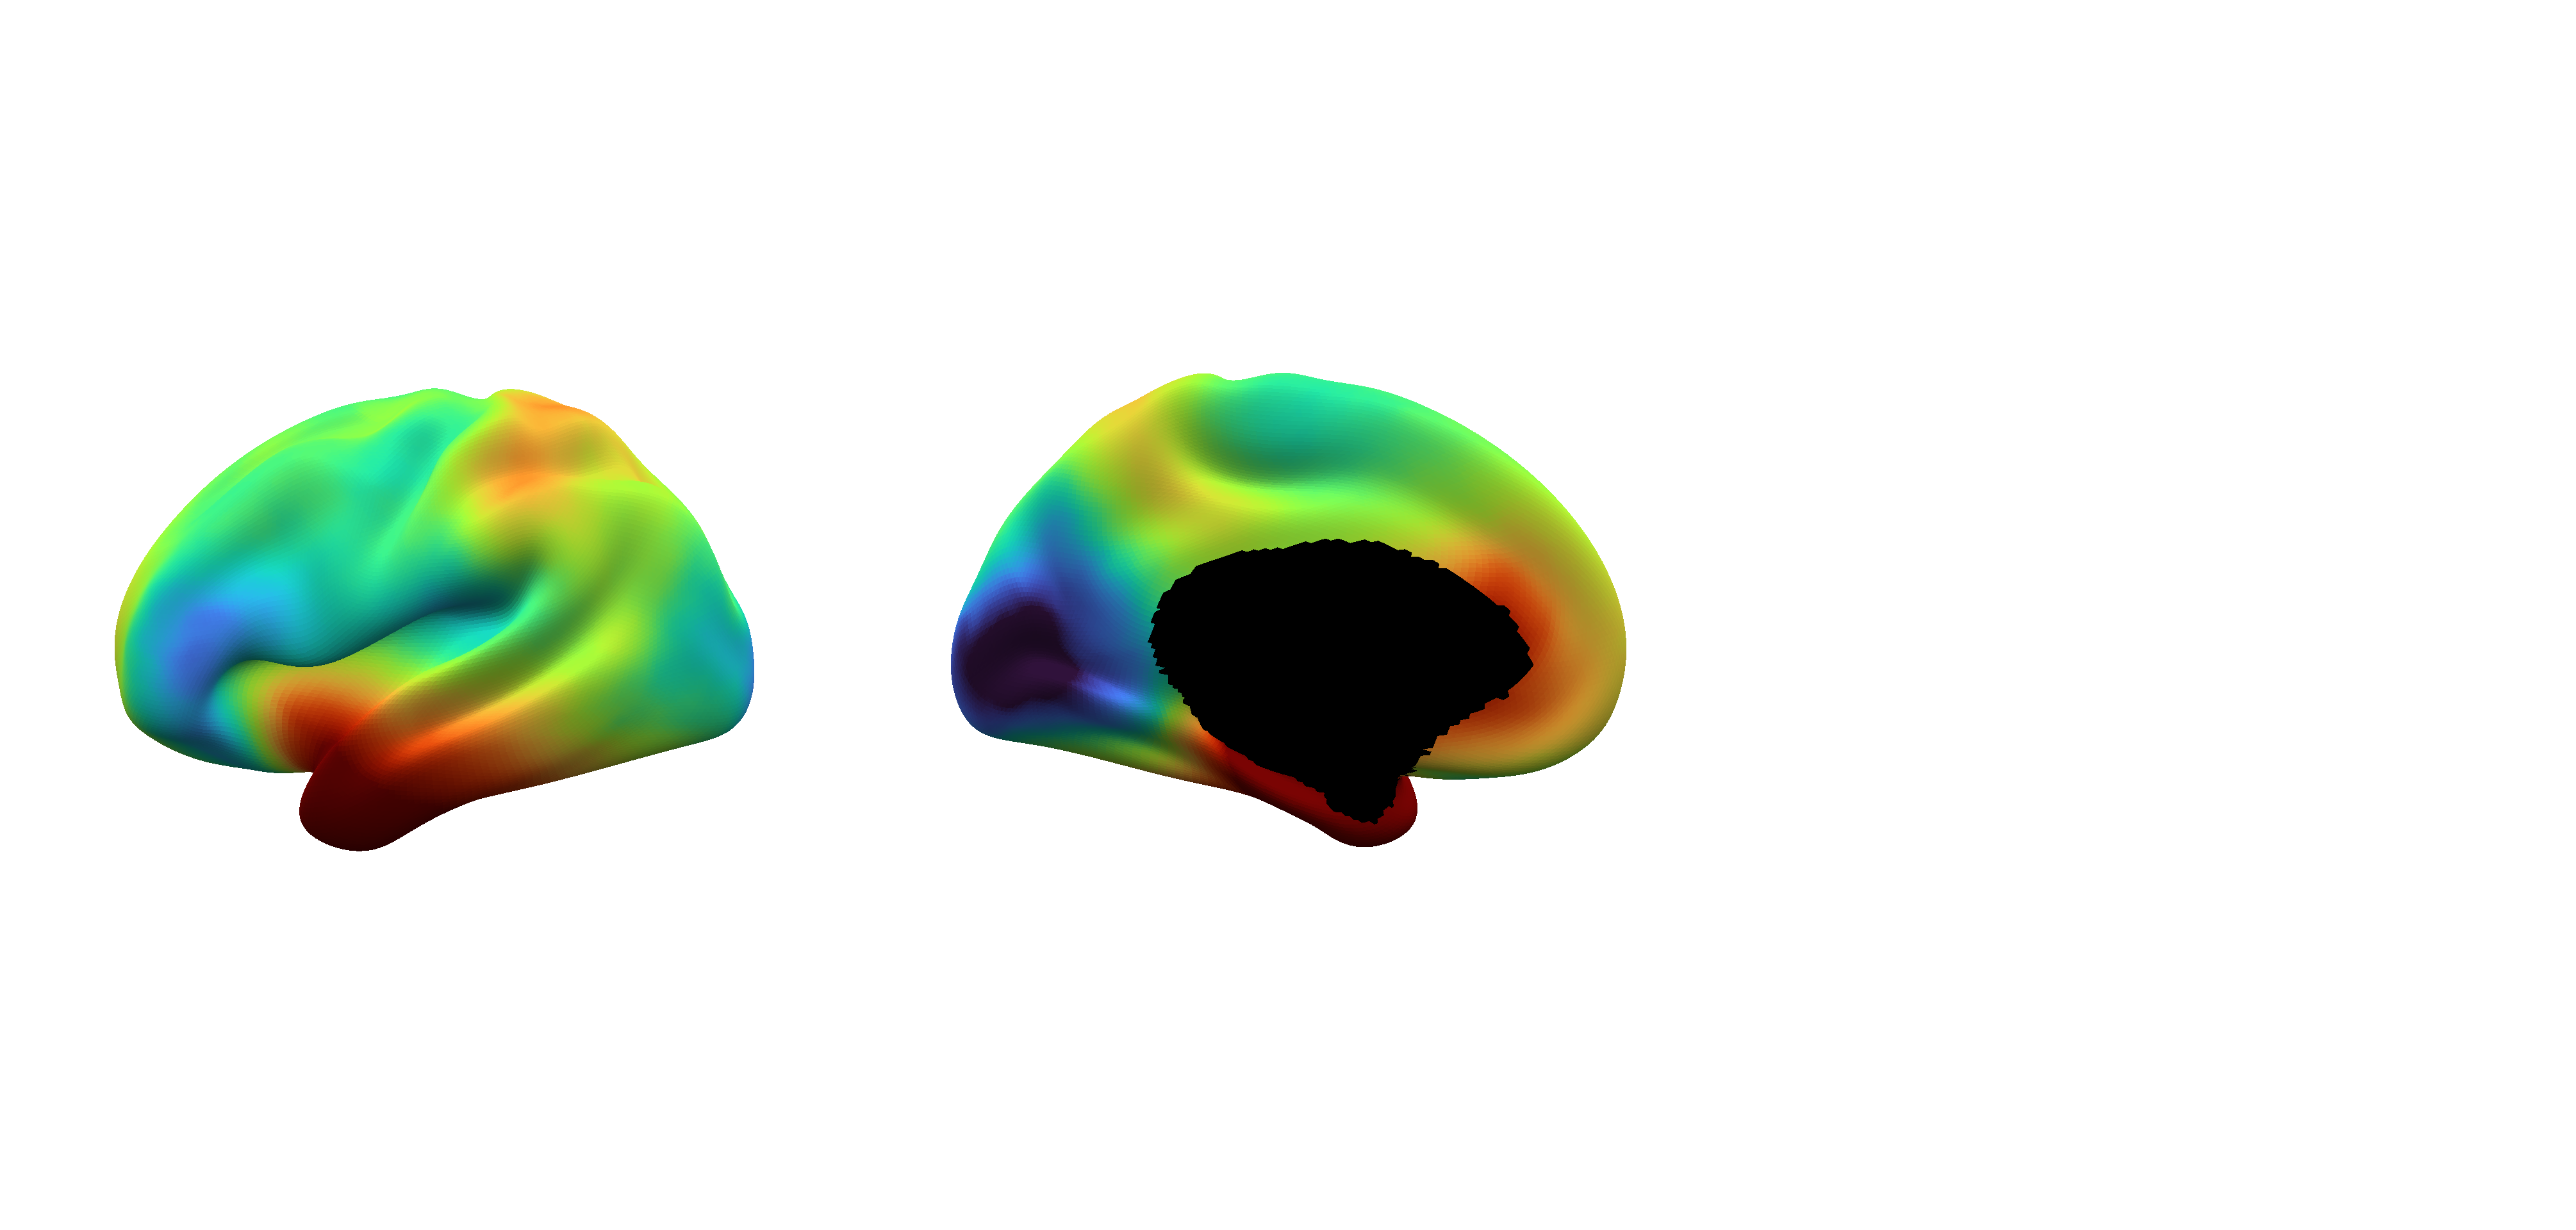

In [23]:
apoe=np.where(pd.read_csv('gene_info.csv')['gene.symbol']=='APOE')[0][0]
apoe_map=concat[apoe]
surf=nb.load(os.path.join(base_dir,'hcp_surfs', 'fs_LR32k',
                                'fs_LR.32k.L.inflated.surf.gii'))
apoe_map=(apoe_map-np.mean(apoe_map[cortex]))/np.std(apoe_map[cortex])
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,apoe_map,
              rotate=[90,270],base_size=20,
             cmap='turbo',vmin=-2,
              vmax=2,mask=~cortex,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
              colorbar=False,
              filename='figures/apoe_map.png'
             )


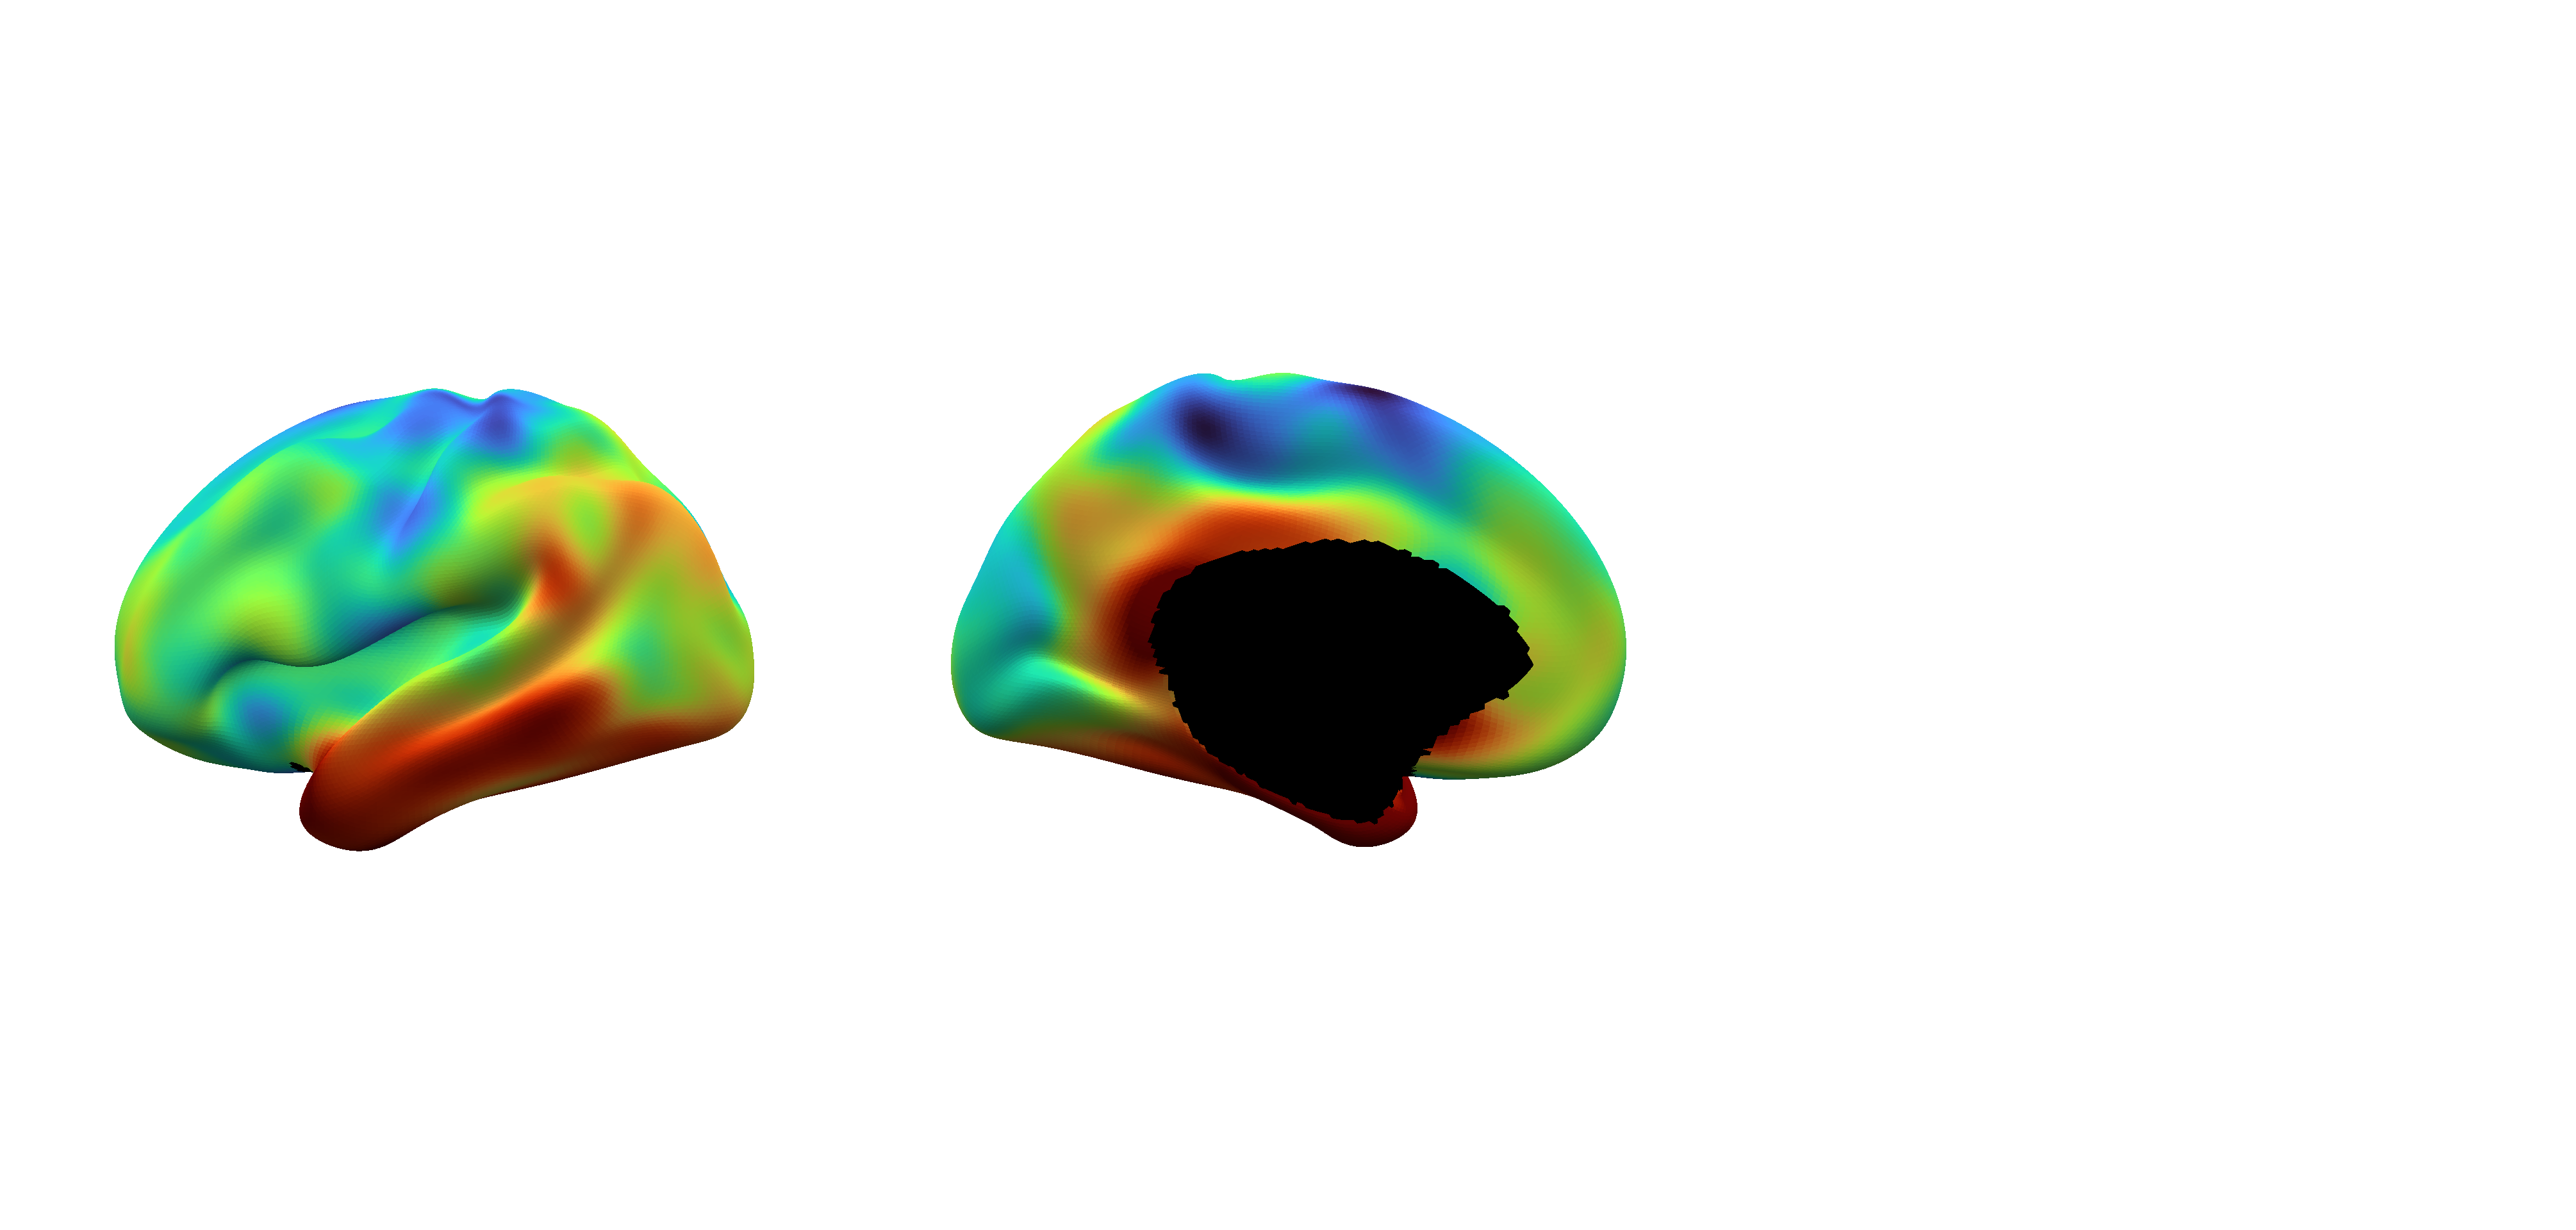

In [32]:
apoe_thinning=nb.load("/data1/oasis/notebooks/fs_LR.32k.L.thickness_apoe.func.gii").darrays[0].data
mask_plus=nb.load("/data1/oasis/notebooks/fs_LR.32k.L.thickness_apoe_cortex.func.gii").darrays[0].data
additional_mask=np.logical_and(mask_plus==0,cortex)
apoe_thinning=(apoe_thinning-np.mean(apoe_thinning[cortex]))/np.std(apoe_thinning[cortex])

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,apoe_thinning,
              rotate=[90,270],base_size=20,
             cmap='turbo_r',
              vmin=-2,
              vmax=2,
                           
              mask=~additional_mask,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
             colorbar=False,
              filename='figures/apoe_thinning_map.png'
             )

In [36]:
map_c=apoe_thinning[cortex]
apoe_map = np.load('surface_mapping/APOE.npy')
apoe_c=apoe_map[cortex]
additional_mask_c=additional_mask[cortex]

corr=np.corrcoef(map_c[additional_mask_c],apoe_c[additional_mask_c])[0,1]


print(corr)

-0.44862897451854944


In [ ]:
#gene_null
permed_ps = np.zeros(20781)
for i,g in enumerate(concat_cortex):
    permed_ps[i] = np.corrcoef(apoe_c,g)[0,1]
np.mean(permed_ps<corr)

In [ ]:
map_c=apoe_thinning[cortex]
apoe_c=apoe_map[cortex]
n_perm=1000
spins= np.load(f'spin_dir/spins_{n_perm}.npy')

corr=np.corrcoef(map_c[additional_mask_c],apoe_c[additional_mask_c])[0,1]
perm_corrs = np.zeros((n_perm))
for p in np.arange(n_perm):
    p1=np.random.randint(n_perm)
    p2=np.random.randint(n_perm)
    if p2==p1:
        print('oops')
        p2=np.random.randint(n_perm)
    spin =spins[p1]
    spun_maps=map_c[spin]
    spin =spins[p2]
    spun_h_maps=apoe_c[spin]
    perm_corrs[p]=np.corrcoef(map_c[additional_mask_c],spun_h_maps[additional_mask_c])[0,1]
    
# nt_scores = (deltas-np.mean(perm_deltas,axis=0))/np.std(perm_deltas,axis=0)
p_val = np.mean(corr>perm_corrs,axis=0)
corr,p_val

In [11]:
from scripts.layer_gene_loader import load_layer_genes

layer_genes=[]
papers=['He','Maynard']

for roi in np.arange(2): 
    layer_genes.append(load_layer_genes(paper=papers[roi]))
combined_layer_genes = layer_genes[0] + layer_genes[1] #+ layer_genes[2]


In [14]:
from sklearn.decomposition import PCA
l=concat[combined_layer_genes[3]]
l4_mean=np.mean(l.argsort().argsort(),axis=0)
pca=PCA(n_components=1)
l4_pc=np.zeros(len(cortex))
pca.fit(concat[combined_layer_genes[3]][:,cortex])
l4_pc[cortex]=pca.components_.ravel()
np.corrcoef(l4_pc[cortex])

1.0

In [15]:
if np.median(np.corrcoef(l4_pc[cortex],concat[combined_layer_genes[3]][:,cortex])[0,1:])<0:
    l4_pc=-l4_pc
import scripts.per_vertex_bb as pvb
lt=pvb.load_lt_cortex(relative=True)

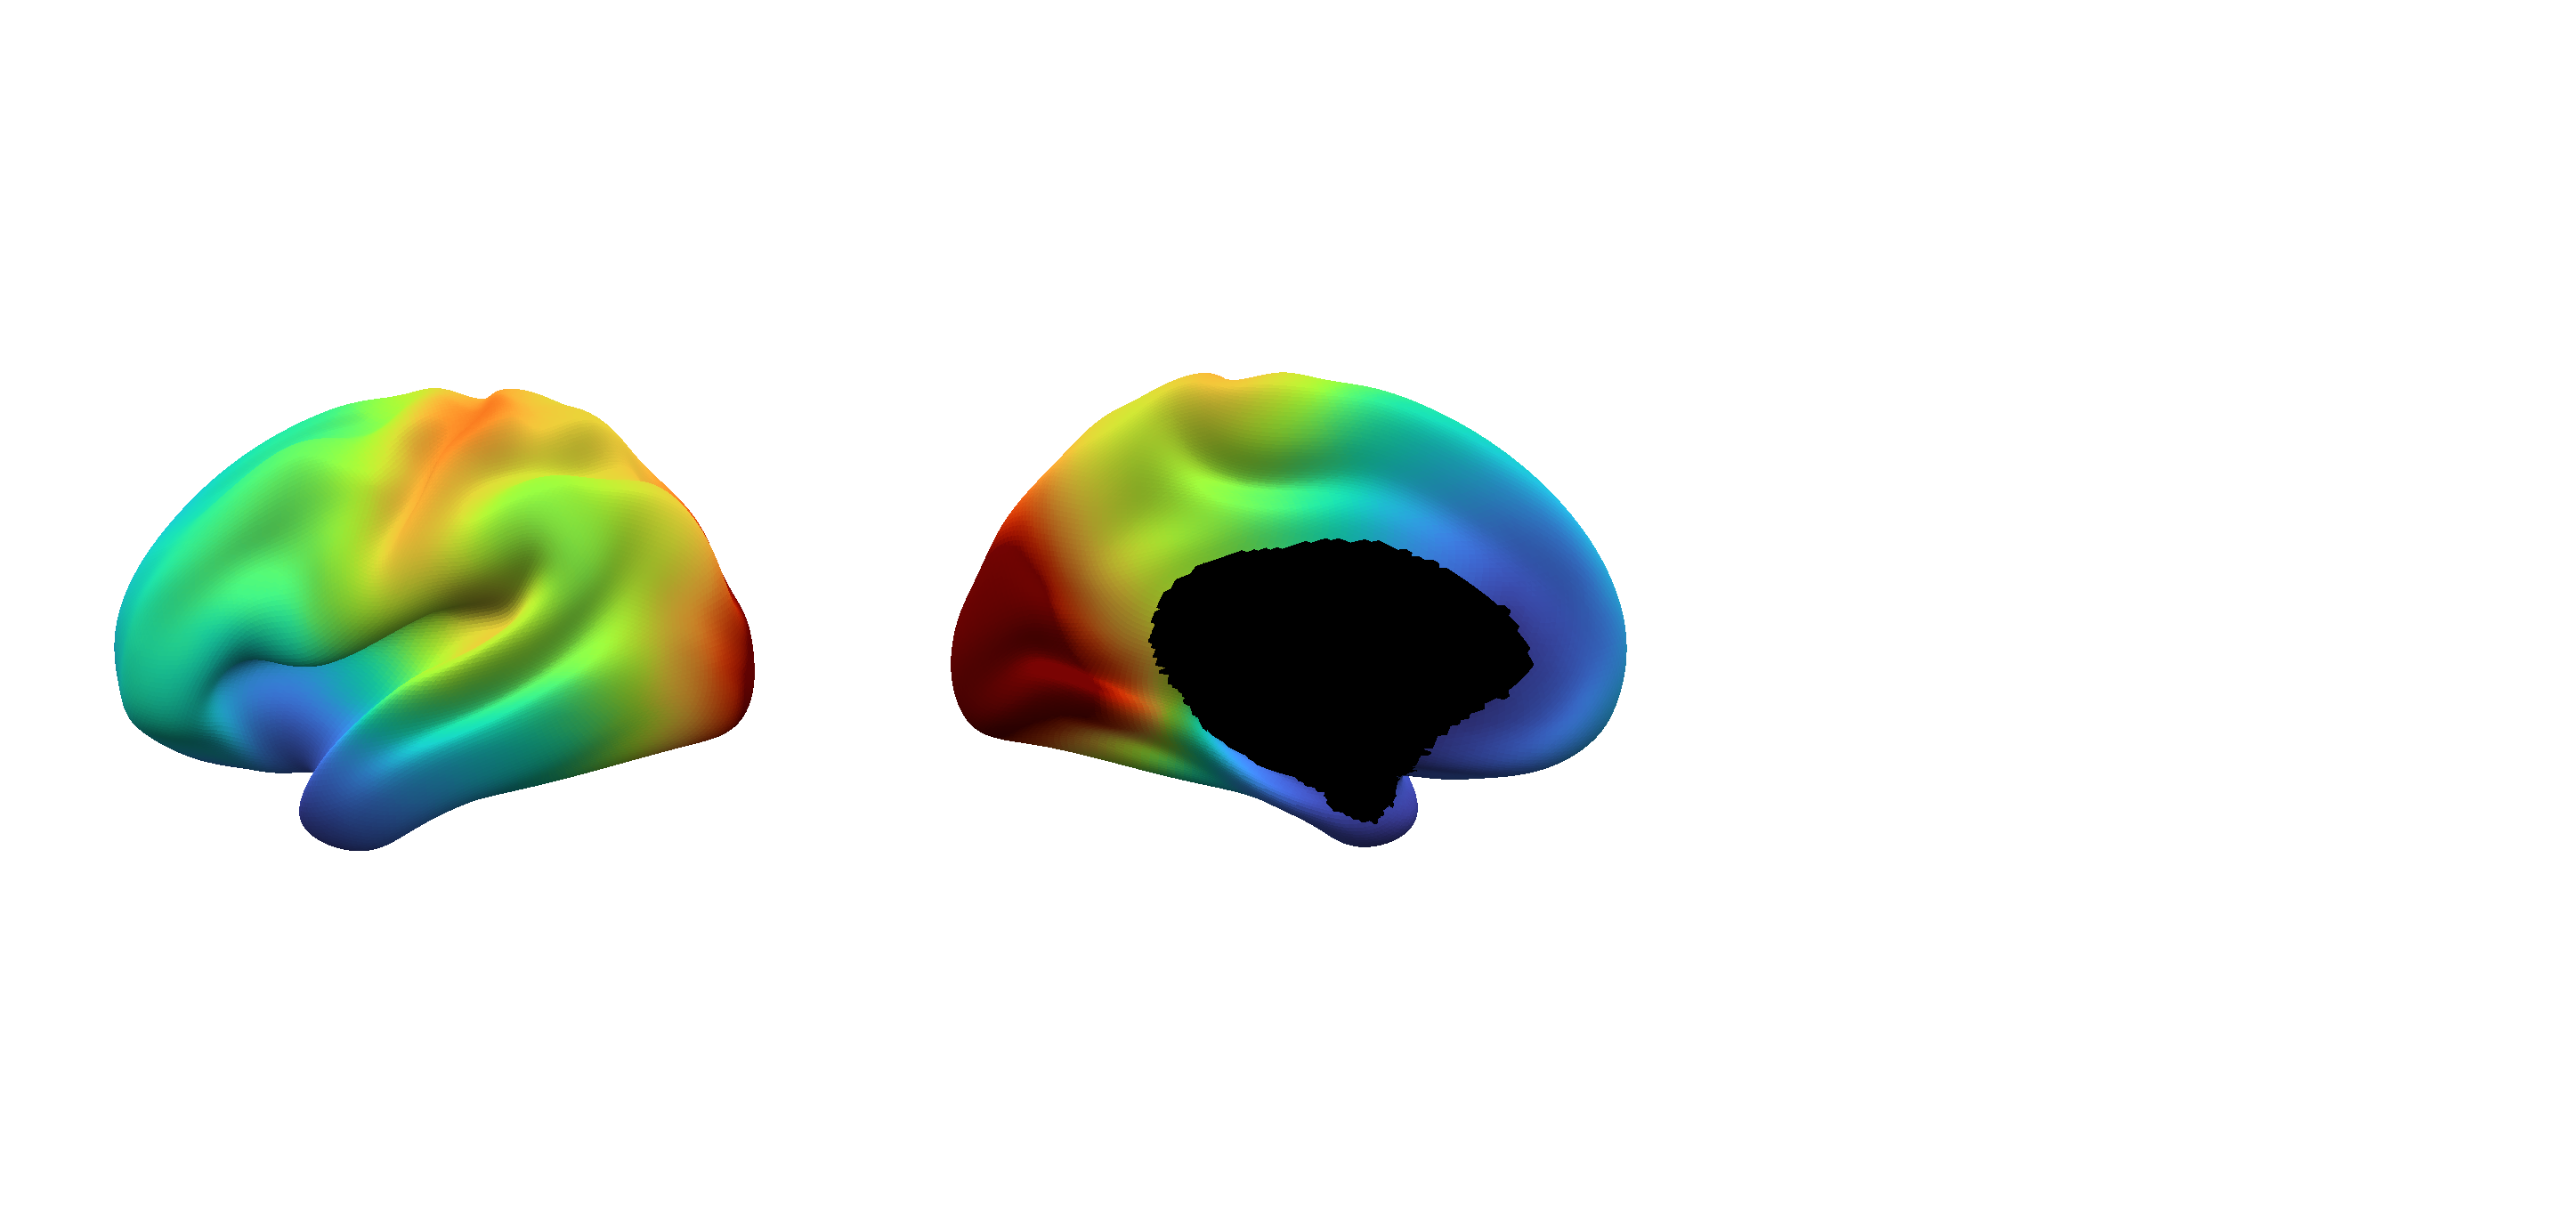

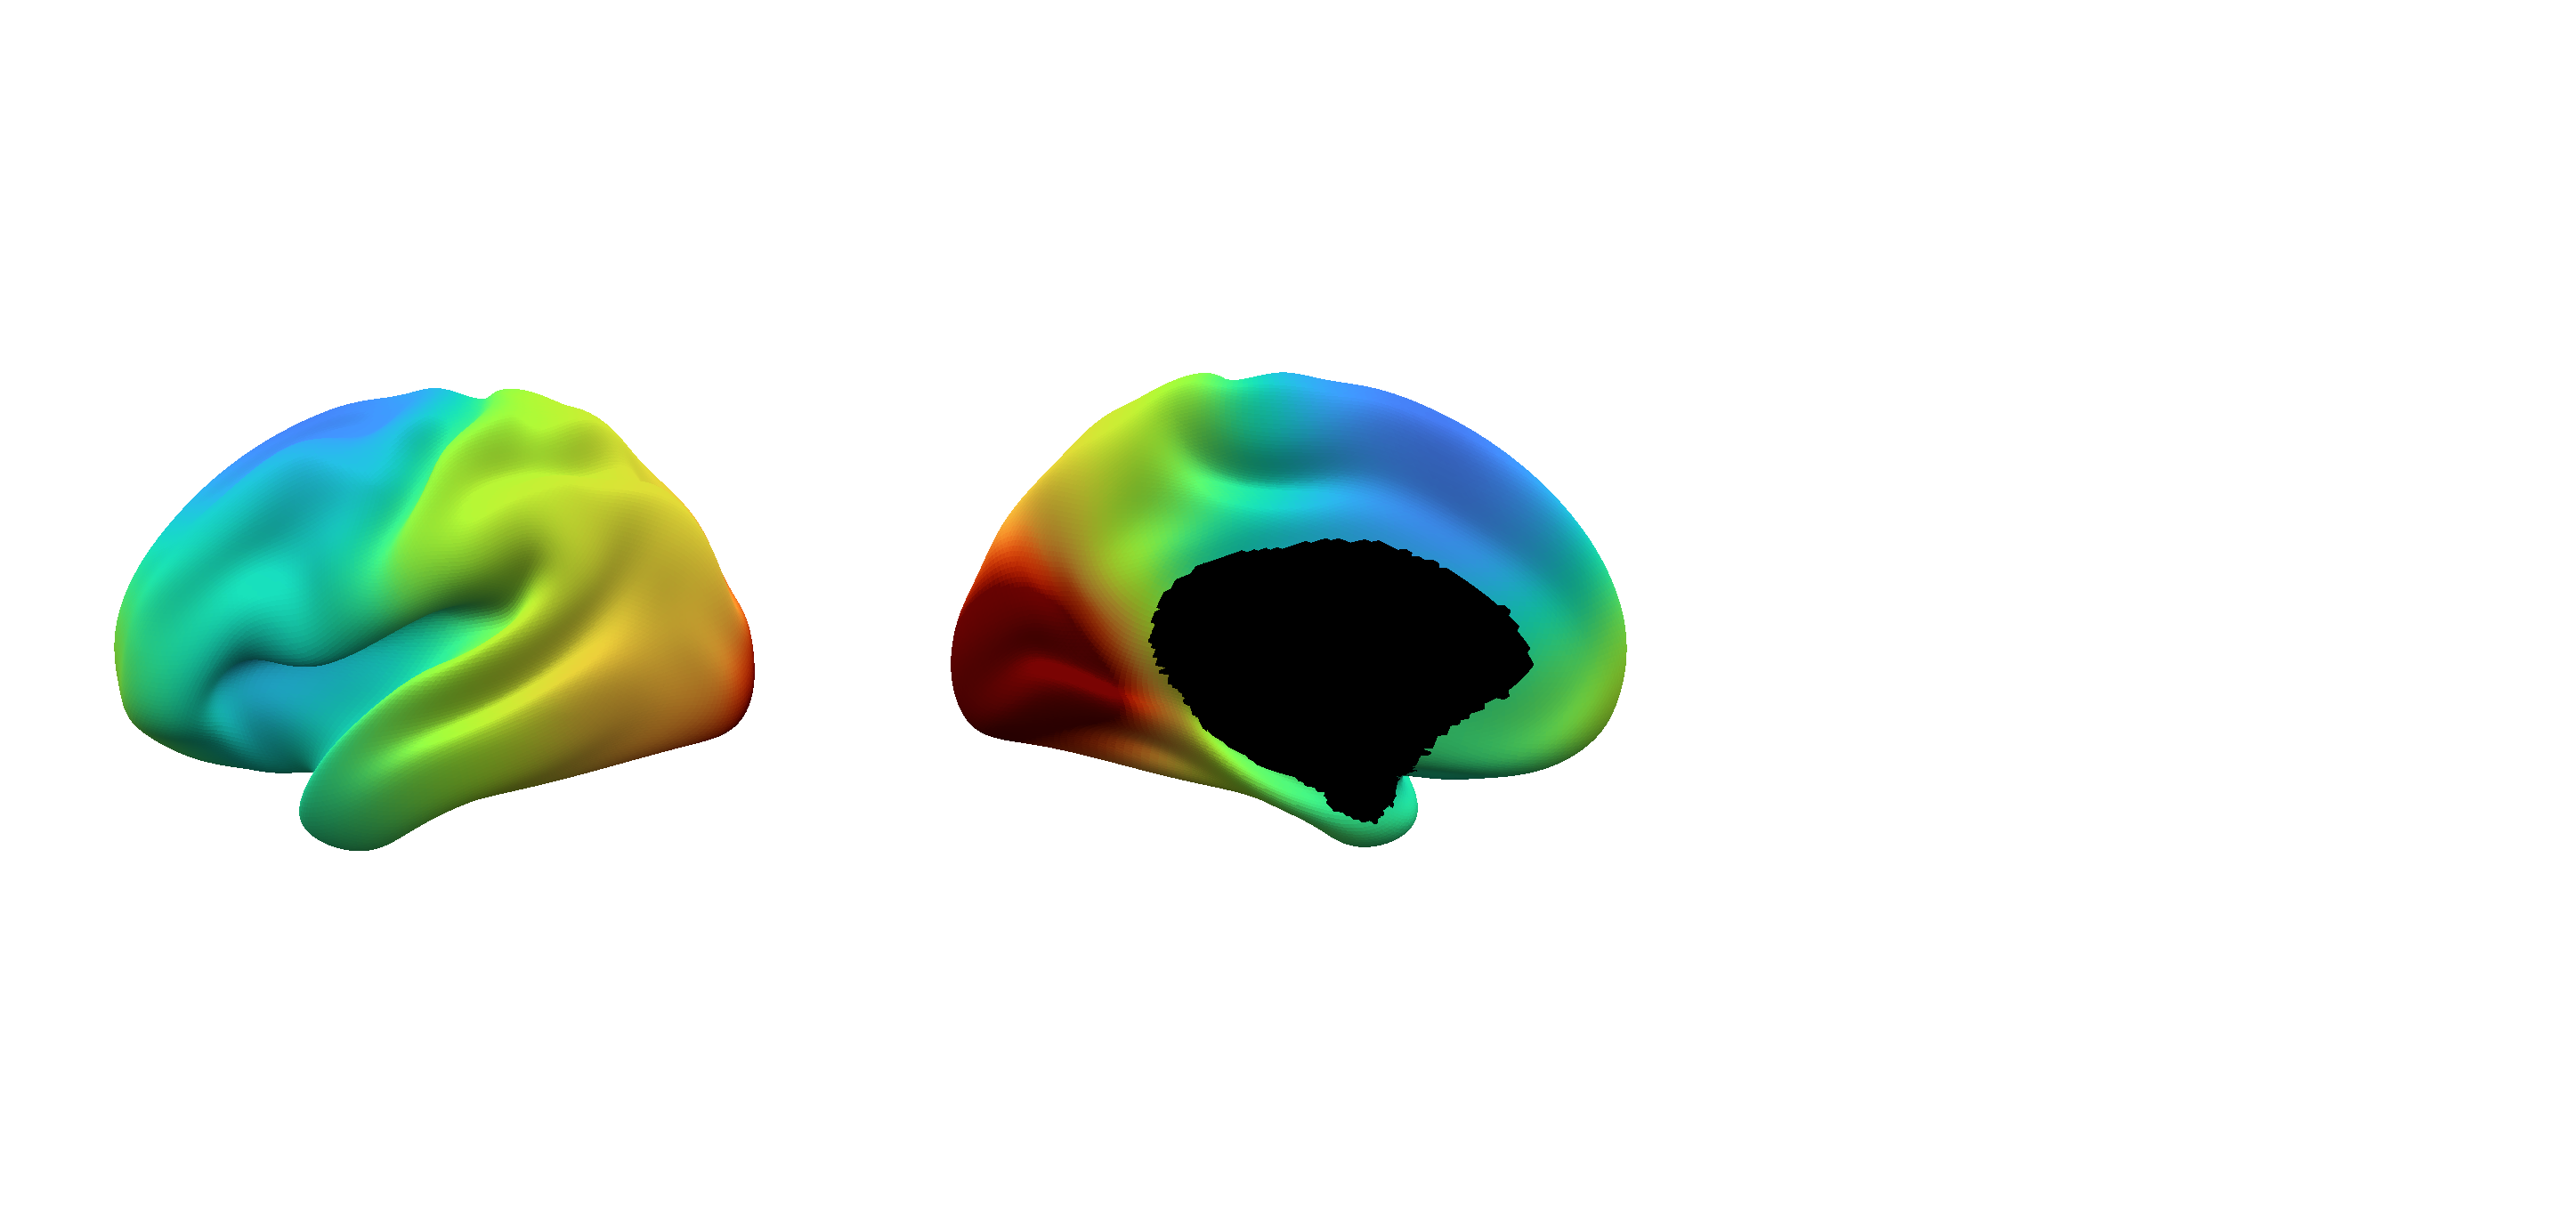

In [30]:
surf=nb.load(os.path.join(base_dir,'hcp_surfs', 'fs_LR32k',
                                'fs_LR.32k.L.inflated.surf.gii'))
l4_pc=(l4_pc-np.mean(l4_pc[cortex]))/np.std(l4_pc[cortex])

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,l4_pc,
              rotate=[90,270],base_size=20,
             cmap='turbo',vmin=-2,
              vmax=2,mask=~cortex,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
              colorbar=False,
              filename='figures/l4_gene_map.png'
             )
full=np.zeros(len(cortex))
full[cortex]=lt[3]
full=(full-np.mean(full[cortex]))/np.std(full[cortex])

msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,full,
              rotate=[90,270],base_size=20,
             cmap='turbo',vmin=-2,
              vmax=2,mask=~cortex,pvals=np.ones_like(cortex),
              mask_colour=np.array([0,0,0,1]),
              colorbar=False,
              filename='figures/l4_thickness_map.png'
             )


In [12]:
n_perm=1000
spins= np.load(f'spin_dir/spins_{n_perm}.npy')

In [ ]:
corrs = np.zeros(20781)
for i,g in enumerate(concat_cortex):
    corrs[i] = np.corrcoef(g,lt[3])[0,1]
ranked_corrs = corrs.argsort().argsort()
l4_genes = combined_layer_genes[3]
median_corr = np.median(ranked_corrs[combined_layer_genes[3]])


In [ ]:
perm_corrs = np.zeros(n_perm)
shuffled_l4 = combined_layer_genes[3].copy()
for p in np.arange(n_perm):
    np.random.shuffle(shuffled_l4)
    perm_corrs[p] = np.median(ranked_corrs[shuffled_l4])

In [ ]:
np.mean(perm_corrs>median_corr)

0.003

In [24]:
map_c=l4_pc[cortex]
hill_c=lt[3]
corr=np.corrcoef(map_c,hill_c)[0,1]

perm_corrs = np.zeros((n_perm))
for p in np.arange(n_perm):
    p1=np.random.randint(n_perm)
    p2=np.random.randint(n_perm)
    while p2==p1:
        print('spins match, regenerating')
        p2=np.random.randint(n_perm)
    spin =spins[p1]
    spun_maps=map_c[spin]
    spin =spins[p2]
    spun_h_maps=hill_c[spin]
    perm_corrs[p]=np.corrcoef(spun_maps,spun_h_maps)[0,1]
    
# nt_scores = (deltas-np.mean(perm_deltas,axis=0))/np.std(perm_deltas,axis=0)
p_val = np.mean(corr<perm_corrs,axis=0)

oops


In [25]:
corr,p_val

(0.7693200210332369, 0.009)